In [1]:
import pandas as pd
import numpy as np
import nltk
import huggingface_hub
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
nltk.download('omw-1.4')
nltk.download('wordnet')
wn = nltk.WordNetLemmatizer()
from bertopic import BERTopic
from umap import UMAP
import re as re
import os 
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from umap import UMAP

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/silvinhad/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/silvinhad/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
data = pd.read_csv('/Users/silvinhad/Desktop/bertopic Python Analysis/gabrielaprioli_tweets.csv').astype("string")
data = data.dropna(subset=["text"])
data.head(3)

,id,author_id,text,edit_history_tweet_ids,possibly_sensitive,in_reply_to_user_id,created_at,referenced_tweets,conversation_id,lang,retweet_count,reply_count,like_count,quote_count
0,1586869510899892225,1215692214849982466,RT @joaopcorisco: a gabriela prioli abrindo o ...,<NA>,False,<NA>,2022-10-30T23:55:48.000Z,<NA>,1586869510899892225,pt,766,0,0,0
1,1586868979338985472,1611661315,RT @joaopcorisco: a gabriela prioli abrindo o ...,<NA>,False,<NA>,2022-10-30T23:53:41.000Z,<NA>,1586868979338985472,pt,766,0,0,0
2,1586866187840921602,217129672,RT @joaopcorisco: a gabriela prioli abrindo o ...,<NA>,False,<NA>,2022-10-30T23:42:36.000Z,<NA>,1586866187840921602,pt,766,0,0,0


In [3]:
data_sample = data.sample(n=30000, random_state=42).reset_index(drop=True)

In [4]:
import re as re
import unicodedata as unicodedata
def basic_clean(string):
    '''
    This function takes in a string and
    returns the string normalized.
    '''
    string = str(string)
    string = string.lower()
    string = re.sub(r'#[A-Za-z0-9]*', ' ', string)
    string = re.sub(r'@[A-Za-z0-9]+', ' ', string)
    string = re.sub(r'[%s]' % re.escape('!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~“…”’'), ' ', string)
    string = re.sub(r'\d+', ' ', string)
    string = re.sub(r'\n+', ' ', string)
    string = re.sub(r"http\S+", "", string)   # URLs
    string = re.sub(r"@\w+", "", string)      # mentions
    string = re.sub(r"\s+", " ", string)
    string = unicodedata.normalize('NFKD', string)\
             .encode('ascii', 'ignore')\
             .decode('utf-8', 'ignore')
    string = re.sub(r'[^\w\s]', '', string).lower()
    return string

data_sample['basic_clean'] = data_sample.text.apply(basic_clean).astype("string")
data_sample['basic_clean']

0        rt a gabriela prioli abrindo o twitter e vendo...
1        rt tipo assim pq vc quer saber o que a gabriel...
2        rt vc viu os stories de gabriela prioli amiga ...
3                                 pagina fb t co p xxnn gp
4        rt vc viu os stories de gabriela prioli amiga ...
                               ...                        
29995                                gabriela prioli e vc 
29996                rt de volta ao esgoto t co c vxvu yfx
29997    rt vc viu os stories de gabriela prioli amiga ...
29998    rt bolsonaro odeia mulheres a apresentadora ga...
29999    rt fora bolsonaro gabriela prioli jair renan r...
Name: basic_clean, Length: 30000, dtype: string

In [5]:
def tokenize(string):
    '''
    This function takes in a string and
    returns a tokenized string.
    '''
    # Create tokenizer.
    tokenizer = nltk.tokenize.ToktokTokenizer()

    # Use tokenizer
    string = tokenizer.tokenize(string, return_str = True)

    return string

data_sample['tokenize'] = data_sample.basic_clean.apply(tokenize).astype("string")
data_sample['tokenize']

0        rt a gabriela prioli abrindo o twitter e vendo...
1        rt tipo assim pq vc quer saber o que a gabriel...
2        rt vc viu os stories de gabriela prioli amiga ...
3                                 pagina fb t co p xxnn gp
4        rt vc viu os stories de gabriela prioli amiga ...
                               ...                        
29995                                 gabriela prioli e vc
29996                rt de volta ao esgoto t co c vxvu yfx
29997    rt vc viu os stories de gabriela prioli amiga ...
29998    rt bolsonaro odeia mulheres a apresentadora ga...
29999    rt fora bolsonaro gabriela prioli jair renan r...
Name: tokenize, Length: 30000, dtype: string

In [6]:
def lemmatize(string):
    '''
    This function takes in string for and
    returns a string with words lemmatized.
    '''
    # Create the lemmatizer.
    wnl = nltk.stem.WordNetLemmatizer()

    # Use the lemmatizer on each word in the list of words we created by using split.
    lemmas = [wnl.lemmatize(word) for word in string.split()]

    # Join our list of words into a string again and assign to a variable.
    string = ' '.join(lemmas)
    
    return string

data_sample['lemmatize'] = data_sample.tokenize.apply(lemmatize).astype("string")
data_sample['lemmatize']

0        rt a gabriela prioli abrindo o twitter e vendo...
1        rt tipo assim pq vc quer saber o que a gabriel...
2        rt vc viu o story de gabriela prioli amiga eh ...
3                                 pagina fb t co p xxnn gp
4        rt vc viu o story de gabriela prioli amiga eh ...
                               ...                        
29995                                 gabriela prioli e vc
29996                rt de volta ao esgoto t co c vxvu yfx
29997    rt vc viu o story de gabriela prioli amiga eh ...
29998    rt bolsonaro odeia mulheres a apresentadora ga...
29999    rt forum bolsonaro gabriela prioli jair renan ...
Name: lemmatize, Length: 30000, dtype: string

In [7]:
import pandas as pd

stopwords = pd.read_csv('/Users/silvinhad/Desktop/bertopic Python Analysis/Portuguese_stopwords.csv', header=None) [0].tolist()

print(len(stopwords))   # should be 432
print(stopwords[:10])   # preview

433
['word', '4k3oos92am', 'a', 'à', 'afirma', 'afirmou', 'agora', 'aí', 'ainda', 'além']


In [8]:
def remove_stopwords(string, extra_words = [], exclude_words = []):
    '''
    This function takes in a string, optional extra_words and exclude_words parameters
    with default empty lists and returns a string.
    '''
    # Create stopword_list.
    stopword_list = stopwords
    
    # Remove 'exclude_words' from stopword_list to keep these in my text.
    stopword_list = set(stopword_list) - set(exclude_words)
    
    # Add in 'extra_words' to stopword_list.
    stopword_list = stopword_list.union(set(extra_words))

    # Split words in string.
    words = string.split()
    
    # Create a list of words from my string with stopwords removed and assign to variable.
    filtered_words = [word for word in words if word not in stopword_list]
    
    # Join words in the list back into strings and assign to a variable.
    string_without_stopwords = ' '.join(filtered_words)
    
    return string_without_stopwords

data_sample['text_without_stopwords'] = data_sample.lemmatize.apply(remove_stopwords).astype("string")
data_sample['text_without_stopwords']


0        gabriela prioli abrindo twitter aulas politica...
1        tipo pq saber gabriela prioli rica gravida nov...
2                 story gabriela prioli amiga eh claro nao
3                                    pagina fb t p xxnn gp
4                 story gabriela prioli amiga eh claro nao
                               ...                        
29995                                      gabriela prioli
29996                            volta esgoto t c vxvu yfx
29997             story gabriela prioli amiga eh claro nao
29998    bolsonaro odeia mulheres apresentadora gabriel...
29999    forum bolsonaro gabriela prioli jair renan rec...
Name: text_without_stopwords, Length: 30000, dtype: string

In [9]:
data_sample

,id,author_id,text,edit_history_tweet_ids,possibly_sensitive,in_reply_to_user_id,created_at,referenced_tweets,conversation_id,lang,retweet_count,reply_count,like_count,quote_count,basic_clean,tokenize,lemmatize,text_without_stopwords
0,1586569703165726722,153082038,RT @joaopcorisco: a gabriela prioli abrindo o ...,<NA>,False,<NA>,2022-10-30T04:04:28.000Z,<NA>,1586569703165726722,pt,766,0,0,0,rt a gabriela prioli abrindo o twitter e vendo...,rt a gabriela prioli abrindo o twitter e vendo...,rt a gabriela prioli abrindo o twitter e vendo...,gabriela prioli abrindo twitter aulas politica...
1,1578483084994805760,782417234417311744,RT @andreariell: tipo assim… pq vc quer saber ...,<NA>,False,<NA>,2022-10-07T20:31:08.000Z,<NA>,1578483084994805760,pt,5109,0,0,0,rt tipo assim pq vc quer saber o que a gabriel...,rt tipo assim pq vc quer saber o que a gabriel...,rt tipo assim pq vc quer saber o que a gabriel...,tipo pq saber gabriela prioli rica gravida nov...
2,1578386816255901701,1204543240273305607,RT @karikrof: “vc viu os stories de gabriela p...,<NA>,False,<NA>,2022-10-07T14:08:36.000Z,<NA>,1578386816255901701,pt,7650,0,0,0,rt vc viu os stories de gabriela prioli amiga ...,rt vc viu os stories de gabriela prioli amiga ...,rt vc viu o story de gabriela prioli amiga eh ...,story gabriela prioli amiga eh claro nao
3,1572377592006840322,1288329521826062336,Página FB: https://t.co/3P1xXnn1GP,<NA>,False,1.2883295218260623e+18,2022-09-21T00:10:05.000Z,<NA>,1571148048931368960,es,0,0,0,0,pagina fb t co p xxnn gp,pagina fb t co p xxnn gp,pagina fb t co p xxnn gp,pagina fb t p xxnn gp
4,1578410090939432968,2857948475,RT @karikrof: “vc viu os stories de gabriela p...,<NA>,False,<NA>,2022-10-07T15:41:05.000Z,<NA>,1578410090939432968,pt,7650,0,0,0,rt vc viu os stories de gabriela prioli amiga ...,rt vc viu os stories de gabriela prioli amiga ...,rt vc viu o story de gabriela prioli amiga eh ...,story gabriela prioli amiga eh claro nao
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,1556784577120804868,1020733330369761281,"@FriedHardt Gabriela Prioli, é vc?",<NA>,False,846207865.0,2022-08-08T23:29:01.000Z,<NA>,1556773925178249216,pt,0,0,17,0,gabriela prioli e vc,gabriela prioli e vc,gabriela prioli e vc,gabriela prioli
29996,1566218226278842368,756530855422615552,RT @brasil247: De volta ao esgoto https://t.co...,<NA>,False,<NA>,2022-09-04T00:14:58.000Z,<NA>,1566218226278842368,pt,530,0,0,0,rt de volta ao esgoto t co c vxvu yfx,rt de volta ao esgoto t co c vxvu yfx,rt de volta ao esgoto t co c vxvu yfx,volta esgoto t c vxvu yfx
29997,1578512949718945793,961100274,RT @karikrof: “vc viu os stories de gabriela p...,<NA>,False,<NA>,2022-10-07T22:29:49.000Z,<NA>,1578512949718945793,pt,7650,0,0,0,rt vc viu os stories de gabriela prioli amiga ...,rt vc viu os stories de gabriela prioli amiga ...,rt vc viu o story de gabriela prioli amiga eh ...,story gabriela prioli amiga eh claro nao
29998,1565896682746908673,1348433772799275012,RT @CentralEleicoes: 📱BOLSONARO ODEIA MULHERES...,<NA>,False,<NA>,2022-09-03T02:57:16.000Z,<NA>,1565896682746908673,pt,402,0,0,0,rt bolsonaro odeia mulheres a apresentadora ga...,rt bolsonaro odeia mulheres a apresentadora ga...,rt bolsonaro odeia mulheres a apresentadora ga...,bolsonaro odeia mulheres apresentadora gabriel...


In [10]:
# exporting the cleaned tweets to generate a wordcloud (part 2)
data_sample.text_without_stopwords.to_csv(r'tweets_sample_gabrielaprioli_cleaned.csv', index=False)

In [11]:
import os
import pandas as pd

from umap import UMAP
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

from gensim import corpora
from gensim.models import CoherenceModel

from bertopic import BERTopic
from hdbscan import HDBSCAN


# ------------------------------------------------------------------
# ENV
# ------------------------------------------------------------------
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# ------------------------------------------------------------------
# EMBEDDINGS (pt-BR)
# ------------------------------------------------------------------

from transformers import AutoModel, AutoTokenizer

model_name = "neuralmind/bert-base-portuguese-cased"

# Load the tokenizer (handles text conversion)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load the model (the actual BERT model)
model = AutoModel.from_pretrained(model_name)

embedding_model = SentenceTransformer(
    "neuralmind/bert-base-portuguese-cased"
)

# ------------------------------------------------------------------
# UMAP
# ------------------------------------------------------------------
umap_model = UMAP(
    n_neighbors=15,
    n_components=10,
    metric="cosine",
    low_memory=False,
    random_state=42
)

# ------------------------------------------------------------------
# VECTORIZER (n-grams)
# ------------------------------------------------------------------
vectorizer_model = CountVectorizer(
    ngram_range=(1, 2),
    min_df=5
)

# ------------------------------------------------------------------
# BERTopic
# ------------------------------------------------------------------
hdbscan_model = HDBSCAN(
    min_cluster_size=30,
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True
)

topic_model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    embedding_model=embedding_model,
    nr_topics=60,
    calculate_probabilities=True,
    verbose=True
)

# ------------------------------------------------------------------
# FIT MODEL
# ------------------------------------------------------------------
docs = data_sample["text_without_stopwords"].tolist()
topics, _ = topic_model.fit_transform(docs)

# ------------------------------------------------------------------
# GROUP DOCUMENTS PER TOPIC (REMOVE OUTLIERS)
# ------------------------------------------------------------------
### WE NEED TO ADD THE NUMBER OF TWEETS PER TOPIC HERE!!!

documents = pd.DataFrame({
    "Document": docs,
    "Topic": topics
})

documents = documents[documents.Topic != -1]

documents_per_topic = (
    documents
    .groupby("Topic", as_index=False)
    .agg(
        tweets_count=("Document", "count"),
        Document=("Document", " ".join)
    )
)

No sentence-transformers model found with name neuralmind/bert-base-portuguese-cased. Creating a new one with MEAN pooling.
2026-01-12 23:36:07,068 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/938 [00:00<?, ?it/s]

2026-01-12 23:38:14,532 - BERTopic - Embedding - Completed ✓
2026-01-12 23:38:14,540 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2026-01-12 23:39:27,281 - BERTopic - Dimensionality - Completed ✓
2026-01-12 23:39:27,288 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-12 23:43:22,850 - BERTopic - Cluster - Completed ✓
2026-01-12 23:43:22,853 - BERTopic - Representation - Extracting topics from clusters using representation models.
2026-01-12 23:43:23,682 - BERTopic - Representation - Completed ✓
2026-01-12 23:43:23,682 - BERTopic - Topic reduction - Reducing number of topics
2026-01-12 23:43:24,371 - BERTopic - Topic reduction - Reduced number of topics from 458 to 60


In [12]:
# exporting document and topics
documents.to_csv(r'topics_tweets_gabrielaprioli.csv',index=False)
documents_per_topic.to_csv(r'topics_grouped_gabrielaprioli.csv', index=False)

In [13]:
documents_per_topic

,Topic,tweets_count,Document
0,0,4907,gravida gabriela prioli cruelmente ameacada el...
1,1,4840,story gabriela prioli amiga eh claro nao story...
2,2,3718,tipo pq saber gabriela prioli rica gravida nov...
3,3,1370,gabriela prioli dizendo nao manifestar corte d...
4,4,919,gabriela prioli leu tanto livro pena nenhum en...
5,5,828,x outubro gente palco gabriela prioli t xkmukr...
6,6,807,mulher gravida seis gabriela prioli atacada bo...
7,7,778,bolsonaro gabinete odio resolveram atacar advo...
8,8,581,gabriela prioli q nao bolsonaro programa respo...
9,9,552,gabriela prioli abrindo twitter aulas politica...


In [14]:

# ------------------------------------------------------------------
# TOKENIZATION (ALIGNED WITH VECTORIZER)
# ------------------------------------------------------------------
analyzer = vectorizer_model.build_analyzer()

tokens = [
    analyzer(doc)
    for doc in documents_per_topic.Document
]

# ------------------------------------------------------------------
# GENSIM STRUCTURES
# ------------------------------------------------------------------
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(text) for text in tokens]

# ------------------------------------------------------------------
# EXTRACT & FILTER TOPIC WORDS (CRITICAL FIX)
# ------------------------------------------------------------------
topic_words = []

for topic in documents_per_topic.Topic:
    words = topic_model.get_topic(topic)
    if words is None:
        continue

    # keep only tokens known by gensim dictionary
    valid_words = [
        word for word, _ in words
        if word in dictionary.token2id
    ]

    # coherence requires at least 2 words
    if len(valid_words) >= 2:
        topic_words.append(valid_words)

# ------------------------------------------------------------------
# SAFETY CHECKS
# ------------------------------------------------------------------
assert len(topic_words) > 0, "No valid topics for coherence"
assert len(topic_words) <= len(tokens), "Topics/texts misalignment"

# ------------------------------------------------------------------
# COHERENCE
# ------------------------------------------------------------------
coherence_model = CoherenceModel(
    topics=topic_words,
    texts=tokens,
    corpus=corpus,
    dictionary=dictionary,
    coherence="c_v"
)

coherence = coherence_model.get_coherence()

print(f"Topic coherence (c_v): {coherence:.4f}")

Topic coherence (c_v): 0.5188


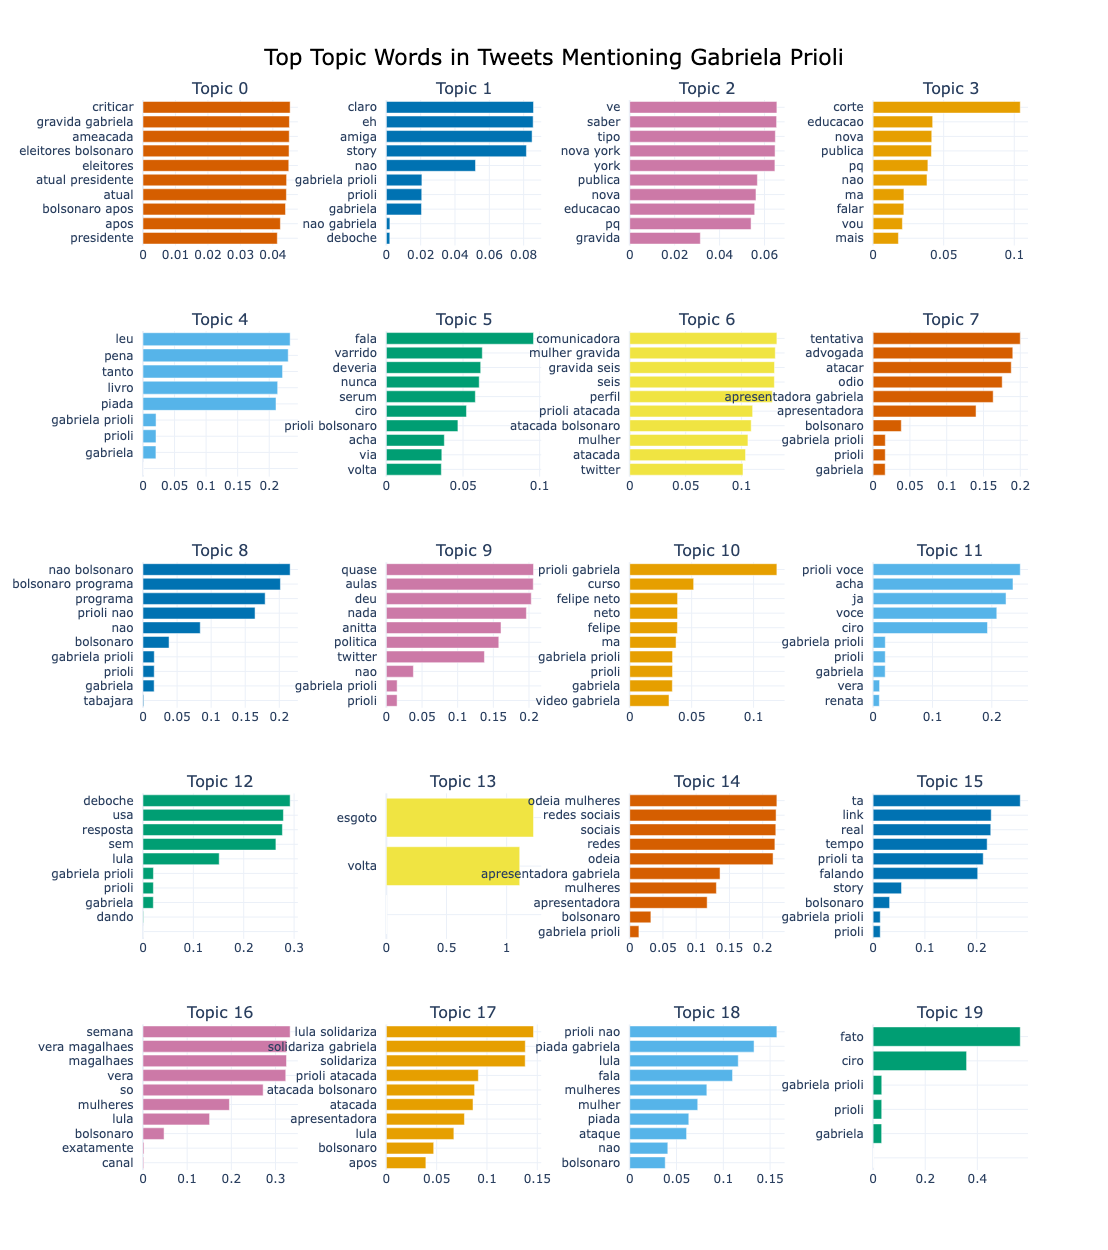

In [15]:
fig = topic_model.visualize_barchart(top_n_topics=20, n_words=10)

fig.update_layout(
    title_text="Top Topic Words in Tweets Mentioning Gabriela Prioli"
)

fig.show()

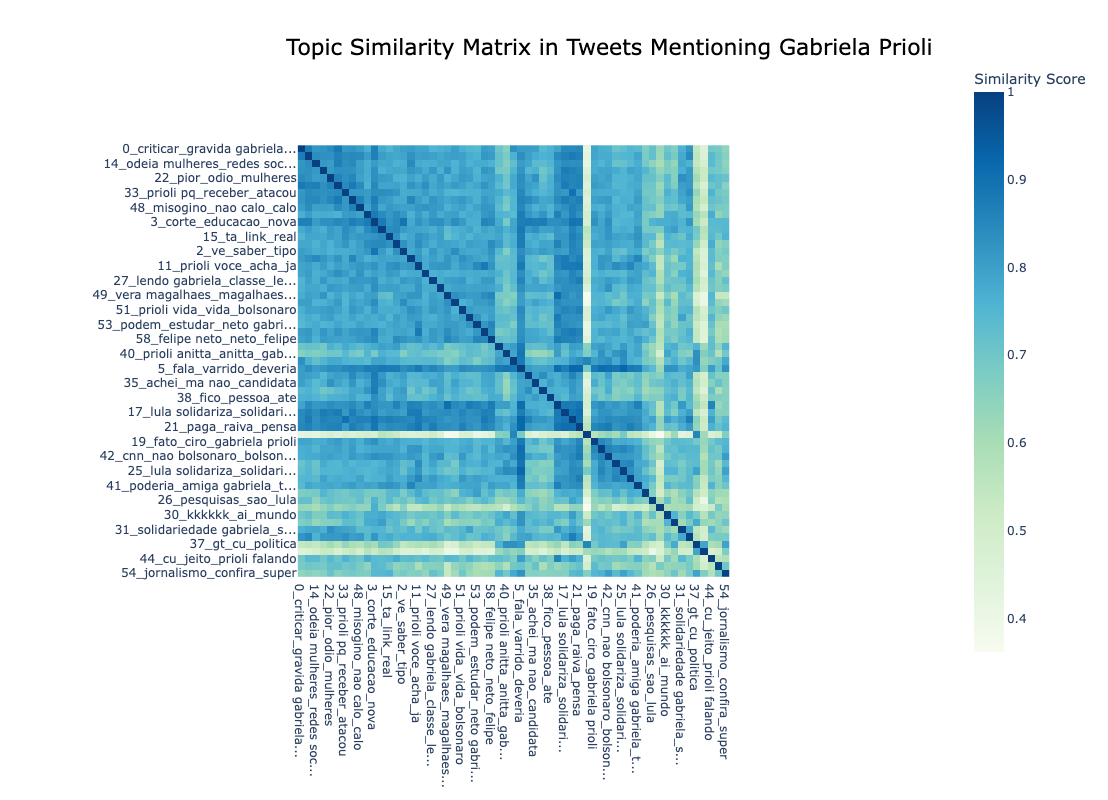

In [16]:
fig2 = topic_model.visualize_heatmap(n_clusters=20)

fig2.update_layout(
    title_text="Topic Similarity Matrix in Tweets Mentioning Gabriela Prioli"
)

fig2.show()


In [17]:
documents

,Document,Topic
0,gabriela prioli abrindo twitter aulas politica...,9
1,tipo pq saber gabriela prioli rica gravida nov...,2
2,story gabriela prioli amiga eh claro nao,1
3,pagina fb t p xxnn gp,37
4,story gabriela prioli amiga eh claro nao,1
...,...,...
29993,gravida gabriela prioli cruelmente ameacada el...,0
29994,story gabriela prioli amiga eh claro nao,1
29995,gabriela prioli,10
29996,volta esgoto t c vxvu yfx,13


In [18]:
import openai
from bertopic.representation import OpenAI
import os
os.environ["OPENAI_API_KEY"] = "ADD YOUR OPENAI KEY HERE" 

client = openai.OpenAI(api_key=os.environ["OPENAI_API_KEY"])

topic_model.update_topics(
    docs,
    topics=topics,
    representation_model=OpenAI(
        client,
        model="gpt-4o-mini",
        delay_in_seconds=5
    )
)
topic_model.get_topic_info()


2026-01-12 23:43:32,831 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
100%|███████████████████████████████████████████| 60/60 [05:42<00:00,  5.71s/it]


,Topic,Count,Name,Representation,Representative_Docs
0,-1,3281,-1_Political discussions in Brazil,[Political discussions in Brazil],[mauricio gabriela prioli quintessencia cinism...
1,0,4907,0_Threats against public figures,[Threats against public figures],[gravida gabriela prioli cruelmente ameacada e...
2,1,4840,1_Conversational interactions on social media,[Conversational interactions on social media],"[story gabriela prioli amiga eh claro nao, sto..."
3,2,3718,2_Unknown/Not relevant content,[Unknown/Not relevant content],[tipo pq saber gabriela prioli rica gravida no...
4,3,1370,3_Politicians discussing education budget cuts,[Politicians discussing education budget cuts],[gabriela prioli dizendo nao manifestar corte ...
5,4,919,4_Unintelligible text,[Unintelligible text],[gabriela prioli leu tanto livro pena nenhum e...
6,5,828,5_Unintelligible text,[Unintelligible text],[gabriela prioli bolsonaro serum varrido volta...
7,6,807,6_Incident involving Gabriela Prioli and Bolso...,[Incident involving Gabriela Prioli and Bolson...,[mulher gravida seis gabriela prioli atacada b...
8,7,778,7_Political attacks and intimidation in Brazil,[Political attacks and intimidation in Brazil],[bolsonaro gabinete odio resolveram atacar adv...
9,8,581,8_Political commentary and satire,[Political commentary and satire],[gabriela prioli q nao bolsonaro programa resp...


In [19]:
topic_info = topic_model.get_topic_info()

final_topics = topic_info.merge(
    documents_per_topic[["Topic", "tweets_count"]],
    on="Topic",
    how="left"
)

final_topics.to_csv(
    "bertopic_topics_openai_gabrielaprioli.csv",
    index=False,
    encoding="utf-8"
)

In [20]:
import scipy.cluster.hierarchy as sch

linkage_function = lambda x: sch.linkage(
    x,
    method="single",
    optimal_ordering=True
)

hierarchical_topics = topic_model.hierarchical_topics(
    docs,
    linkage_function=linkage_function
)


100%|███████████████████████████████████████████| 58/58 [05:29<00:00,  5.68s/it]


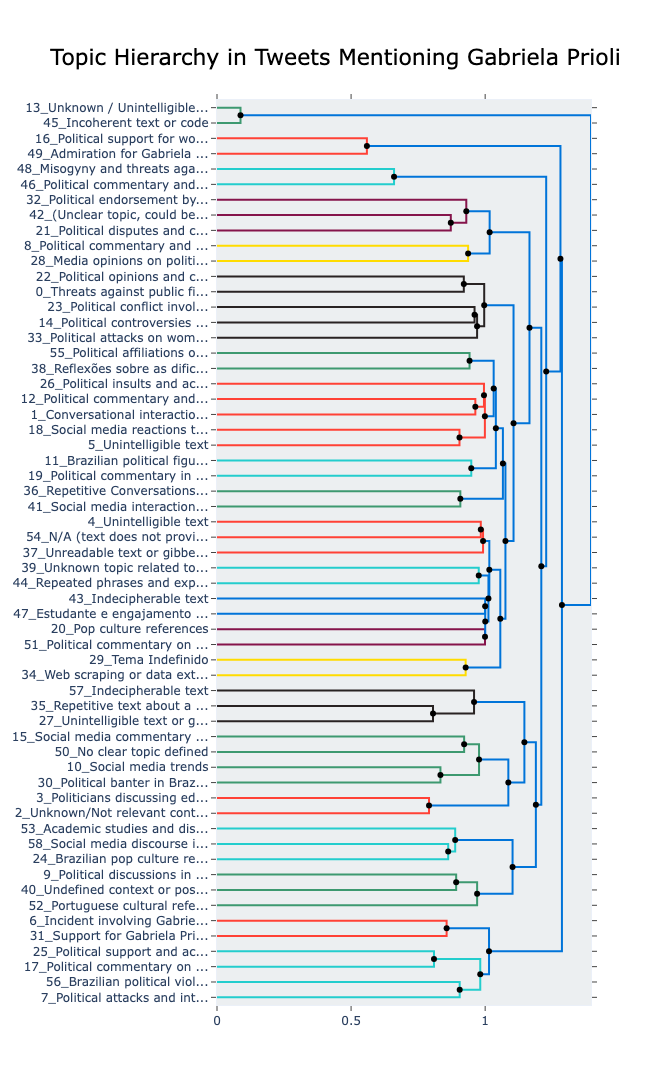

In [21]:
fig3 = topic_model.visualize_hierarchy(
    hierarchical_topics=hierarchical_topics
)

fig3.update_layout(
    title_text="Topic Hierarchy in Tweets Mentioning Gabriela Prioli"
)

fig3.show()


In [22]:
hierarchical_topics.to_csv(
    "hierarchical_topics_gabrielaprioli.csv",
    index=False
)
